<a href="https://colab.research.google.com/github/jolied-14/MLE-F2025/blob/main/ProjectProgress4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Progress 4

Name: Jolie Dolan<br>
RIN: 662020565

In [12]:
# Initial Setup
# Import libraries and load dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load dataset
df = pd.read_csv('/content/sample_data/Data2.csv')

print("Dataset Loaded Successfully.\n")

# Show first rows
display(df.head())

# Dataset summary
print("\nDataset Info:")
print(df.info())

Dataset Loaded Successfully.



,Name,P1 _Convergence Length,P2 Divergence Length,P3_InletDiameter,P4_Throttle_Diameter,P5_ExitDiameter,P7_Pressure_Inlet,P6_Velocity
0,DP 0,15,15,12,3,15,1378950,119.130700
1,DP 1,28,30,21,1,9,474973,25.174023
2,DP 2,19,17,13,3,20,1285097,97.235954
3,DP 3,20,24,19,1,23,382353,28.955469
4,DP 4,13,14,11,3,13,822234,130.119600



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Name                    1001 non-null   object 
 1   P1 _Convergence Length  1001 non-null   int64  
 2   P2 Divergence Length    1001 non-null   int64  
 3   P3_InletDiameter        1001 non-null   int64  
 4   P4_Throttle_Diameter    1001 non-null   int64  
 5   P5_ExitDiameter         1001 non-null   int64  
 6   P7_Pressure_Inlet       1001 non-null   int64  
 7   P6_Velocity             1001 non-null   float64
dtypes: float64(1), int64(6), object(1)
memory usage: 62.7+ KB
None


## Part 1: Decision Tree Utilization for Classifying Flow Regime

In [13]:
# Solve Mach from area ratio using isentropic relations
from scipy.optimize import fsolve

gamma = 1.4

def area_mach_relation(M, AR, gamma=1.4):
    """Isentropic area-Mach relation set equal to AR."""
    return ((((2/(gamma+1)) * (1 + (gamma-1)/2 * M**2)))**((gamma+1)/(2*(gamma-1))) / M) - AR

def solve_mach(AR, supersonic=True):
    """Solve Mach from area ratio.
       If supersonic=True, solve for M > 1.
       Otherwise solve for M < 1."""
    if supersonic:
        M_initial = 2.0
    else:
        M_initial = 0.2
    M_solution = fsolve(area_mach_relation, M_initial, args=(AR,))
    return float(M_solution[0])

In [14]:
import numpy as np
import pandas as pd

# constants
gamma = 1.4
P_ambient = 101325  # Pa

# Compute actual area ratios
A_throat = (np.pi/4) * (df['P4_Throttle_Diameter']**2)
A_exit = (np.pi/4) * (df['P5_ExitDiameter']**2)

df["AR_exit"] = A_exit / A_throat

# Solve for exit Mach (supersonic branch)
df["M_exit"] = df["AR_exit"].apply(lambda AR: solve_mach(AR, supersonic=True))
df["NPR_ideal"] = (1 + (gamma-1)/2 * df["M_exit"]**2)**(gamma/(gamma-1))

P_ambient = 101325  # Pa

df["NPR_actual"] = df["P7_Pressure_Inlet"] / P_ambient

def classify_regime(row, epsilon=0.05):
    NPR_a = row["NPR_actual"]
    NPR_i = row["NPR_ideal"]

    if NPR_a > NPR_i * (1 + epsilon):
        return "underexpanded"
    elif NPR_a < NPR_i * (1 - epsilon):
        return "overexpanded"
    else:
        return "ideally expanded"

df["FlowRegime"] = df.apply(classify_regime, axis=1)


/tmp/ipython-input-3209984569.py:18: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  M_solution = fsolve(area_mach_relation, M_initial, args=(AR,))


In [15]:
df["FlowRegime"].value_counts()


,count
FlowRegime,
overexpanded,864
underexpanded,117
ideally expanded,20


In [28]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df["FlowRegime"])

print("Encoder classes:", encoder.classes_)
print("Sample encoded labels:", y_encoded[:10])

Encoder classes: ['ideally expanded' 'overexpanded' 'underexpanded']
Sample encoded labels: [1 1 1 1 1 1 1 1 1 1]


### corrected method

In [35]:
# train–test split + classifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# select features
feature_cols = [
    "P1 _Convergence Length",
    "P2 Divergence Length",
    "P3_InletDiameter",
    "P4_Throttle_Diameter",
    "P5_ExitDiameter",
    "P6_Velocity",
    "P7_Pressure_Inlet",
    "AR_exit",
    "M_exit",
    "NPR_actual",
    "NPR_ideal"
]

X = df[feature_cols]

y = y_encoded  # <-- use encoded labels consistently

# train–test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train/Test split complete.")
print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Train/Test split complete.
Training samples: 700
Testing samples: 301


In [36]:
print("Train label distribution:", np.bincount(y_train))
print("Test label distribution:", np.bincount(y_test))
print("Decoder mapping:", dict(enumerate(encoder.classes_)))


Train label distribution: [ 14 604  82]
Test label distribution: [  6 260  35]
Decoder mapping: {0: 'ideally expanded', 1: 'overexpanded', 2: 'underexpanded'}


In [37]:
# Decision Tree with class weighting
dtree = DecisionTreeClassifier(
    class_weight="balanced",
    max_depth=6,
    random_state=42
)

dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)


Accuracy: 0.9966777408637874

Classification Report:
                  precision    recall  f1-score   support

ideally expanded       1.00      0.83      0.91         6
    overexpanded       1.00      1.00      1.00       260
   underexpanded       0.97      1.00      0.99        35

        accuracy                           1.00       301
       macro avg       0.99      0.94      0.97       301
    weighted avg       1.00      1.00      1.00       301



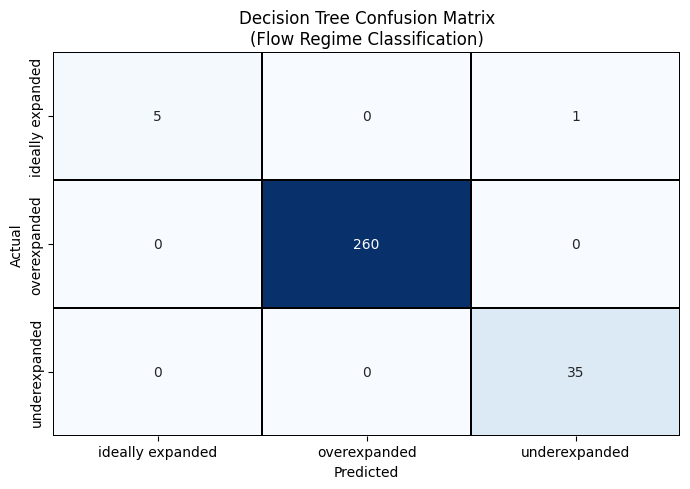

In [39]:
# Model performance
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=encoder.classes_
))

# Use numeric labels for encoded data
cm = confusion_matrix(
    y_test,
    y_pred,
    labels=[0, 1, 2]   # encoded class values
)

plt.figure(figsize=(7,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_,
    cbar=False,
    linewidths=0.1,
    linecolor="black"
)
plt.title("Decision Tree Confusion Matrix\n(Flow Regime Classification)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

The confusion matrix shows that the decision tree classifier performs exceptionally well in identifying nozzle flow regimes. Underexpanded and overexpanded flows are classified with 100% accuracy. The model only misclassified a single ideally expanded case as underexpanded, which is expected given the small size of the ideal class and the narrow NPR tolerance defining this regime. These results demonstrate that the physics-derived features (area ratios, estimated Mach number, and nozzle pressure ratios) enable clear separation of flow regimes, and the model effectively captures the underlying compressible-flow behavior.

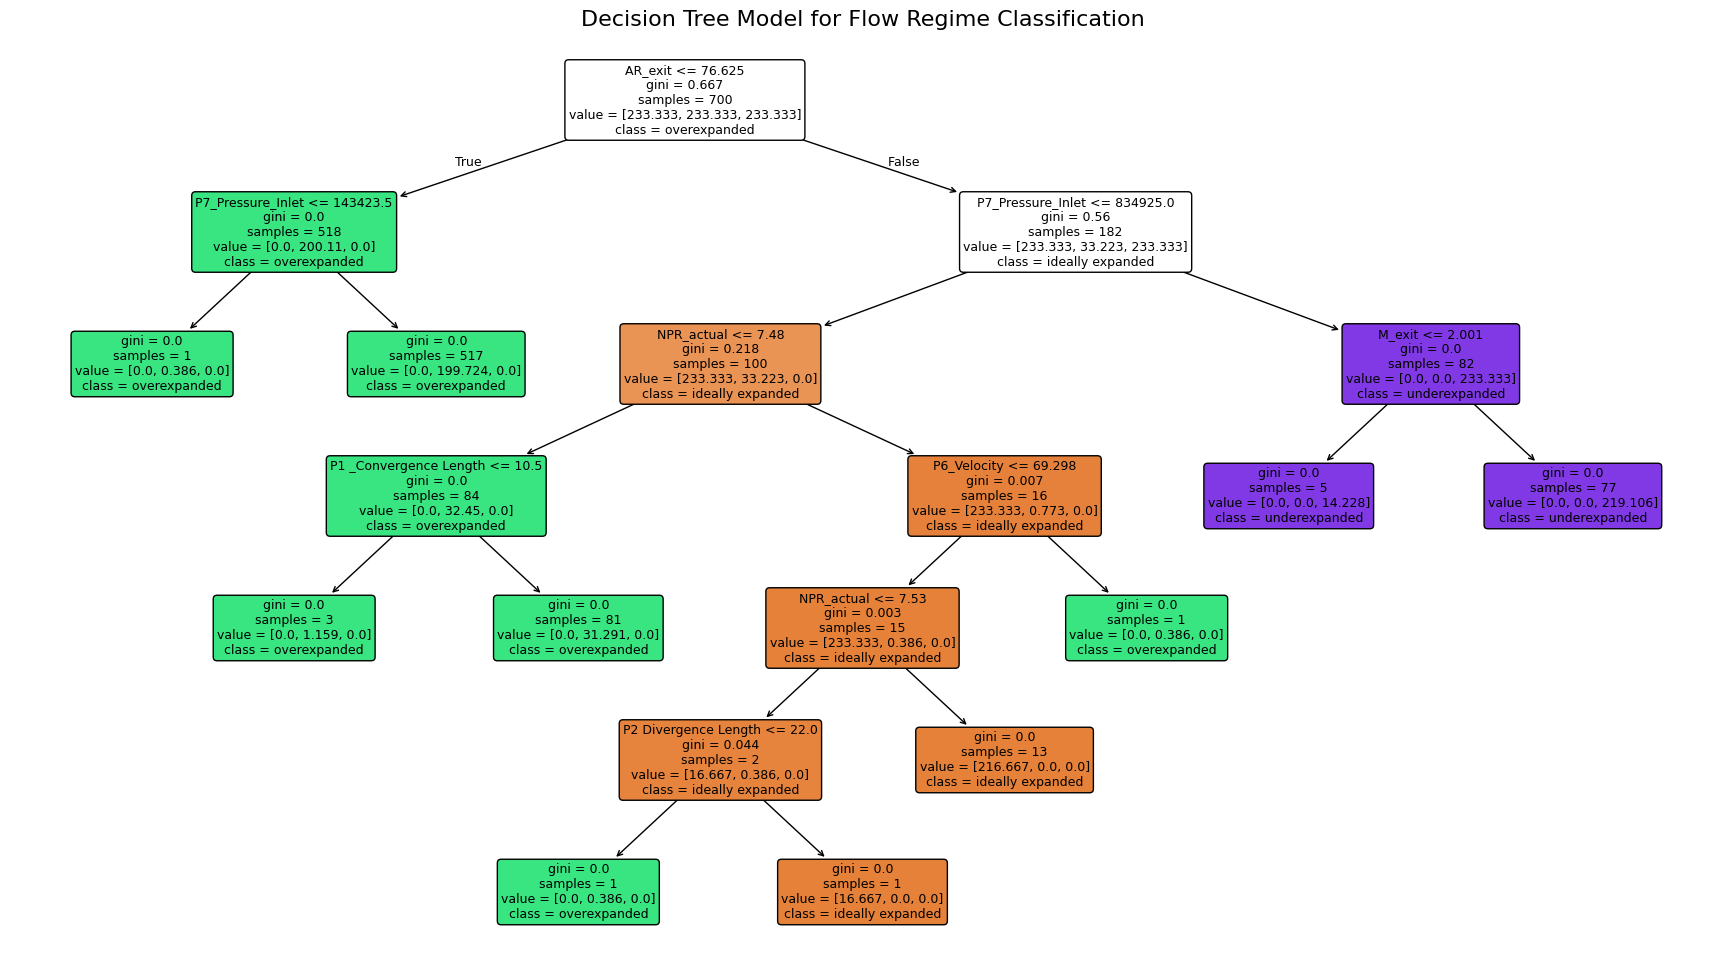

In [40]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 12))

tree.plot_tree(
    dtree,
    feature_names=feature_cols,
    class_names=encoder.classes_,
    filled=True,
    rounded=True,
    fontsize=9
)

plt.title("Decision Tree Model for Flow Regime Classification", fontsize=16)
plt.show()

The decision tree classifier provides a physically interpretable mapping between nozzle operating conditions and the resulting jet expansion regime (overexpanded, ideally expanded, or underexpanded). The structure of the tree reflects fundamental compressible-flow relationships, particularly the dependence of jet expansion behavior on geometry, pressure ratios, and exit Mach number.

Essentially, the decision tree effectively performs a hierarchy of physics-driven decisions:
1. Global geometric capability (AR_exit) determines whether the nozzle can expand the jet sufficiently.
2. Operating pressure ratio (NPR_actual) determines whether the actual operating conditions match the nozzle's design expansion level.
3. Local geometric and velocity effects refine the identification of ideal flow regions.
4. Exit Mach number cleanly distinguishes high-energy underexpanded jets.

This alignment between machine learning logic and classical fluid-dynamics theory validates both the quality of the dataset and the interpretable performance of the decision tree model.

### original code - no longer relevant, but helpful for comprehension

assisted in determining need for change in physics compressible flow approach to create everything in the corrected method portion.

In [ ]:
import numpy as np
import pandas as pd

# constants
gamma = 1.4
P_ambient = 101325  # Pa


# compute areas
df['A_inlet'] = np.pi * (df['P3_InletDiameter']**2) / 4
df['A_throat'] = np.pi * (df['P4_Throttle_Diameter']**2) / 4
df['A_exit'] = np.pi * (df['P5_ExitDiameter']**2) / 4


# area ratios
df['CR_inlet_to_throat'] = df['A_inlet'] / df['A_throat']
df['ER_throat_to_exit'] = df['A_exit'] / df['A_throat']


# invert area-mach for exit Mach
def area_mach_relation(M, gamma=1.4):
    """ Isentropic area-Mach relation A/A* for given Mach number M """
    term1 = 1/M
    term2 = ((2/(gamma+1)) * (1 + (gamma-1)/2 * M**2))**((gamma+1)/(2*(gamma-1)))
    return term1 * term2

def solve_exit_mach(area_ratio, gamma=1.4):
    """
    Numerically solve for exit Mach given A_exit/A_throat.
    We assume supersonic flow in a diverging nozzle.
    """
    # Search Mach range for supersonic solutions
    M_vals = np.linspace(1.0, 10.0, 5000)
    A_vals = area_mach_relation(M_vals, gamma)

    idx = (np.abs(A_vals - area_ratio)).argmin()
    return M_vals[idx]

df['M_exit_estimated'] = df['ER_throat_to_exit'].apply(solve_exit_mach)

# exit static pressure
def isentropic_pressure(P0, M, gamma=1.4):
    return P0 * (1 + (gamma - 1)/2 * M**2)**(-gamma/(gamma-1))

df['P_exit_estimated'] = isentropic_pressure(
    df['P7_Pressure_Inlet'],
    df['M_exit_estimated']
)

# classifying flow regime
def classify_regime(P_exit, P_ambient=101325):
    if P_exit > P_ambient * 1.05:
        return "underexpanded"
    elif P_exit < P_ambient * 0.95:
        return "overexpanded"
    else:
        return "ideally_expanded"

df['FlowRegime'] = df['P_exit_estimated'].apply(classify_regime)

print("Physics-based features appended successfully!")
df.head()

Physics-based features appended successfully!


,Name,P1 _Convergence Length,P2 Divergence Length,P3_InletDiameter,P4_Throttle_Diameter,P5_ExitDiameter,P7_Pressure_Inlet,P6_Velocity,A_inlet,A_throat,A_exit,CR_inlet_to_throat,ER_throat_to_exit,M_exit_estimated,P_exit_estimated,FlowRegime
0,DP 0,15,15,12,3,15,1378950,119.130700,113.097336,7.068583,176.714587,16.000000,25.000000,5.000400,2605.052241,overexpanded
1,DP 1,28,30,21,1,9,474973,25.174023,346.360590,0.785398,63.617251,441.000000,81.000000,6.613523,164.250117,overexpanded
2,DP 2,19,17,13,3,20,1285097,97.235954,132.732290,7.068583,314.159265,18.777778,44.444444,5.751150,1054.537750,overexpanded
3,DP 3,20,24,19,1,23,382353,28.955469,283.528737,0.785398,415.475628,361.000000,529.000000,9.972995,9.173296,overexpanded
4,DP 4,13,14,11,3,13,822234,130.119600,95.033178,7.068583,132.732290,13.444444,18.777778,4.649330,2362.519338,overexpanded


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# encode target labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

print("Label mapping:")
for cls, code in zip(encoder.classes_, encoder.transform(encoder.classes_)):
    print(f"{cls} → {code}")

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)



Label mapping:
overexpanded → 0


In [ ]:
# select features and target
feature_cols = [
    'P1 _Convergence Length',
    'P2 Divergence Length',
    'P3_InletDiameter',
    'P4_Throttle_Diameter',
    'P5_ExitDiameter',
    'P6_Velocity',
    'P7_Pressure_Inlet',
    'CR_inlet_to_throat',
    'ER_throat_to_exit',
    'M_exit_estimated',
    'P_exit_estimated'
]

X = df[feature_cols]
y = df['FlowRegime']

KeyError: "['CR_inlet_to_throat', 'ER_throat_to_exit', 'M_exit_estimated', 'P_exit_estimated'] not in index"

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# train decision tree
clf = DecisionTreeClassifier(max_depth=6, random_state=42)
clf.fit(X_train, y_train)

# predictions & evaluation
y_pred = clf.predict(X_test)

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0

Confusion Matrix:
 [[301]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       301

    accuracy                           1.00       301
   macro avg       1.00      1.00      1.00       301
weighted avg       1.00      1.00      1.00       301



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


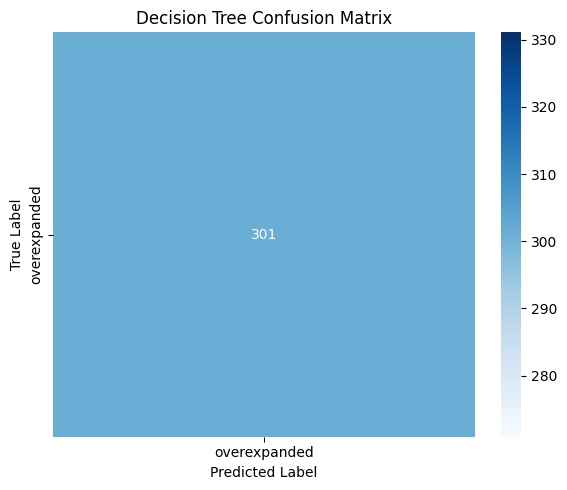

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create labeled categories (using the original encoder)
labels = encoder.classes_

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [ ]:
print(df[['P_exit_estimated', 'FlowRegime']].head())
print(df['FlowRegime'].value_counts())


   P_exit_estimated    FlowRegime
0       2605.052241  overexpanded
1        164.250117  overexpanded
2       1054.537750  overexpanded
3          9.173296  overexpanded
4       2362.519338  overexpanded
FlowRegime
overexpanded    1001
Name: count, dtype: int64


everything ended up being overexpanded, so went to review math since this likely shouldn't be the case. altered the code and mathematical approach to change.